In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import SALib
from SALib.plotting import bar
import seaborn as sns
# read Sobol' sensitivity indices as dataframe
from settings import SOBOL_DATA_DIR, FIGURE_DIR
from utils.Sobol_G_setting import set_sobol_g_func
from pandas.core.common import flatten

## Plot Sobol' SA with dummy parameter included

<Figure size 576x432 with 0 Axes>

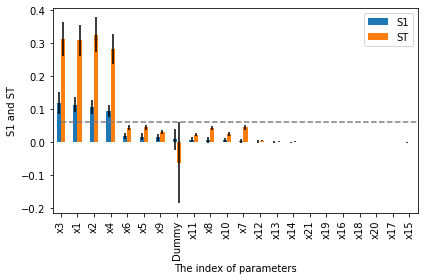

In [4]:
df = pd.read_csv(f'../output/sobol/Sobol_indices.csv', index_col = 'Unnamed: 0')
a, x, x_bounds, x_names, len_params, problem = set_sobol_g_func()

df_plot = pd.DataFrame()
df_plot.loc[:, 'S1'] = df[df.Type == 'S1']['result_5000'].values
df_plot.loc[:, 'S1_conf'] = df[df.Type == 'S1_conf']['result_5000'].values
df_plot.loc[:, 'ST'] = df[df.Type == 'ST']['result_5000'].values
df_plot.loc[:, 'ST_conf'] = df[df.Type == 'ST_conf']['result_5000'].values
threshold = df_plot.loc[21, 'ST'] + df_plot.loc[21, 'ST_conf']

df_plot.index = [* problem['names'], 'Dummy']
df_plot.sort_values(by='S1', ascending=False, inplace=True)
fig = plt.figure(figsize = (8, 6))
ax = bar.plot(df_plot)
# ax.set_xticklabels([* problem['names'], 'Dummy'])
ax.set_xlabel('The index of parameters')
ax.set_ylabel('S1 and ST')
plt.tight_layout()
plt.hlines(threshold, xmin=0, xmax=22, colors = 'grey', linestyle='--')
plt.savefig(f'../output/sobol/Sobol_dummy.png', format = 'png', dpi = 300)

## Plot the adaptive evaluation

In [115]:
from settings import *
df = {}
filename = ['fix_9'] #'fix_9', 'fix_17','fix_1', , 'fix_21', 'fix_10',
fpath = '../output/morris/latin_adaptive/'
for fn in filename:
    df[fn] = pd.read_csv(f'{fpath}{fn}.csv', index_col = 'Unnamed: 0').T.iloc[:500]
    df[fn].index = df[fn].index.astype('int')
    
mse = pd.read_csv(f'{fpath}mse.csv', index_col='Unnamed: 0')

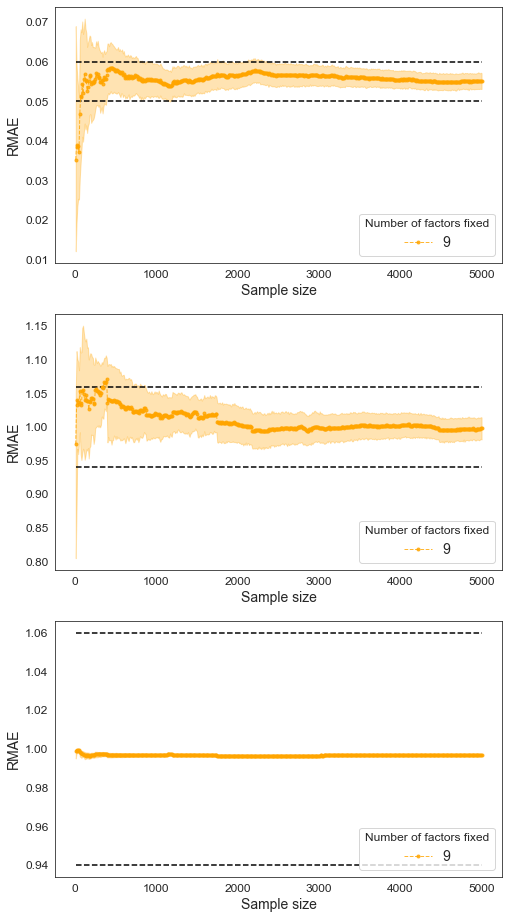

In [116]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 16))
fs = 12
sns.set_style('white')
plt.rcParams['legend.title_fontsize'] = 12
lgd = [ii.split('_')[1] for ii in filename]
# METRIC_NAME = [METRIC_NAME[0]]
metrics = [fn for fn in METRIC_NAME if not '_' in fn ]
for ii in range(len(metrics)):
    metric = metrics[ii]
    for fn in filename:
        df_plot = df[fn]
        logy = True if ii == 0 else False
        ax = df_plot.loc[:, metric].plot(kind='line', marker='o', linewidth=1, style='--', ms=3, ax = axes[ii], alpha=0.8, logy=False, color='orange')
        ax.fill_between(df_plot.index, df_plot.loc[:, f'{metric}_lower'], df_plot.loc[:, f'{metric}_upper'], alpha = 0.3, color='orange')
    if ii == 0:
        ax.hlines(0.06, df_plot.index[0], df_plot.index[-1], linestyle = '--')
        ax.hlines(0.05, df_plot.index[0], df_plot.index[-1], linestyle = '--')
    else:
        ax.hlines(1.06, df_plot.index[0], df_plot.index[-1], linestyle = '--')
        ax.hlines(0.94, df_plot.index[0], df_plot.index[-1], linestyle = '--')
    ax.set_xlabel('Sample size', fontsize=14);
    ax.set_ylabel('RMAE', fontsize = 14);
    # print(ax.get_xticklabels())
    plt.setp(ax.get_xticklabels(), fontsize=12)
    plt.setp(ax.get_yticklabels(), fontsize=12)
    ax.legend(lgd, title='Number of factors fixed', fontsize = 14, ncol=2, loc='lower right')
    # ax.text(200, 0.062, '6% (New threshold)', fontsize=12, color='k')
    # ax.text(200, 0.046, '5% (Old threshold)', fontsize=12, color='k')
# plt.savefig('../output/figure/mae_adaptive_5000.png', format = 'png', dpi = 300)


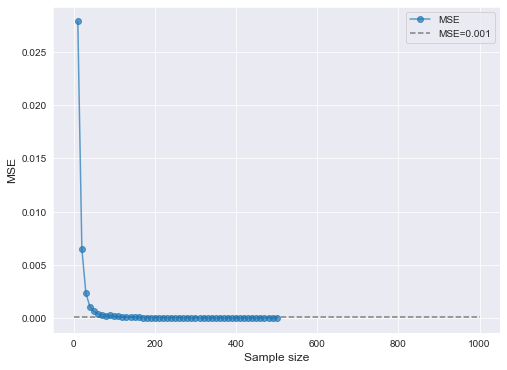

In [70]:
# Plot the MSE of the mean using variance and the sample size
sns.set_style('darkgrid')
ax = mse.iloc[:50].plot(legend=False, figsize = (8, 6), marker = 'o', alpha = 0.7)
ax.set_xlabel('Sample size', fontsize=fs)
ax.set_ylabel('MSE', fontsize=fs)
hlines_value = 0.0001
plt.hlines(hlines_value, xmin=0, xmax=1000, colors='grey', linestyles='--')
ax.legend(['MSE', f'MSE={hlines_value}'])
# plt.savefig('../output/figure/mse_lhs.png', format = 'png', dpi = 300)

In [62]:
df['fix_9']['mae_upper'].iloc[230:240]

2310    0.060057
2320    0.060008
2330    0.060128
2340    0.059967
2350    0.059979
2360    0.059954
2370    0.059929
2380    0.059893
2390    0.059704
2400    0.059999
Name: mae_upper, dtype: float64

## Plot Figure 6 

In [192]:
from settings import *
df = {}
filename = ['fix_6', 'fix_9', 'fix_10', 'fix_11', 'fix_17',] #'fix_1', , 'fix_21',
fpath = '../output/morris/adaptive/'
for fn in filename:
    df[fn] = pd.read_csv(f'{fpath}{fn}.csv', index_col = 'Unnamed: 0').T.iloc[-1]

df_metric = pd.DataFrame(df).T
index = [ii.split('_')[1] for ii in filename]
df_metric.index = index
# df_metric.index = df_metric.index.astype('int')

In [193]:
# obtain relative bias    
cols = df_metric.columns
col_upper = [col for col in cols if 'up' in col]
col_lower = [col for col in cols if 'low' in col]
for ii in range(len(col_upper)):
    df_metric[col_upper[ii]] = df_metric[col_upper[ii]] - df_metric[cols[ii]]
    df_metric[col_lower[ii]] = df_metric[cols[ii]] - df_metric[col_lower[ii]]

df_metric.fillna(value=0.0, inplace=True)
df_metric['ppmc'] = df_metric['ppmc'].apply(lambda x: 1 - x)
df_metric['var'] = df_metric['var'].apply(lambda x: np.abs(1 - x))
df_metric = df_metric.drop_duplicates('mae', keep='first')
yerror = [[df_metric[col_lower[ii]].values, df_metric[col_upper[ii]].values] for ii in range(len(col_upper))]


In [194]:
# import the analytic variance 
fvariance = np.loadtxt('../data/variance_frac.txt')
# total_variance = 2.755
index_fix = np.array([[20], [15, 16, 17, 18, 19], [14, 12, 13], 
                    [11], [8], [10, 9, 7, 6, 5, 4], [2, 3, 0, 1]])
variance_frac = fvariance[[len(list(flatten(index_fix[0:i+1])))-1 for i in range(index_fix.size-1)]] / 100
variance_frac = np.append(variance_frac, fvariance[-1])
variance_frac = variance_frac[[1, 2, 3, 4, 5]]

Text(0.1, 0.08, '6% (Threshold)')

<Figure size 432x360 with 0 Axes>

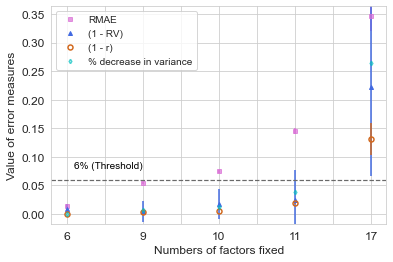

In [195]:

sns.set_style('whitegrid')
fig = plt.figure(figsize=(6, 5))
# form x label
x = df_metric.index
num_in_groups = []
# x_ticklabels = [''] + ['{}{}{}{}'.format(i+1, ' (', (21 - x[i]), ')') for i in range(len(x))]
# df_metric.index = ([i+1 for i in range(len(x))])

conf_names = [col for col in METRIC_NAME if '_conf' in col]
colors = ['orchid', 'royalblue','chocolate']
ax = df_metric[METRIC_NAME[:3]].plot(kind='line', yerr=yerror, 
                                    linestyle='', color=colors)

# x = df_metric.index
ax.plot(x, df_metric[METRIC_NAME[0]], 's', color=colors[0], ms=4, alpha=0.7, label='RMAE')
ax.plot(x, df_metric[METRIC_NAME[1]], '^', color=colors[1], ms=4, label='RV')
ax.plot(x, df_metric[METRIC_NAME[2]], 'o', ms=5, markerfacecolor='none',label='PPMC',
        markeredgecolor=colors[2], markeredgewidth=1.5)
          
ax.plot(x, variance_frac, 'd', ms=3, markerfacecolor='none',label='First-order variance',
        markeredgecolor='c', markeredgewidth=1.5, alpha=0.7)            
                                                                  
ax.axhline(y=0.06, xmin=0, xmax=6, linestyle='--', linewidth=1.2, color='dimgrey')
ax.tick_params(axis='both', labelsize=12)

ax.set_xlabel('Numbers of factors fixed', fontsize=12)
ax.set_ylabel('Value of error measures', fontsize=12)
# ax.set_ylim(-0.03, 0.5)
# ax.set_xlim(0.85, 7.15)

# ax.set_xticklabels(x_ticklabels)
ax.legend(['RMAE', '(1 - RV)', '(1 - r)', '% decrease in variance'], loc='upper left', fontsize=10)
ax.text(0.1, 0.08, '6% (Threshold)', fontsize=10, color='k')
plt.savefig('{}{}{}'.format('../output/figure/', 'fig6_variance_fix', '.png'), dpi=300, format='png')

In [172]:
df_metric

,mae,var,ppmc,mae_lower,var_lower,ppmc_lower,mae_upper,var_upper,ppmc_upper
6,0.013214,0.007053,0.000198,0.001511,0.012762,0.000071,0.001594,0.012968,0.000061
9,0.052373,0.005046,0.002730,0.006582,0.051701,0.001268,0.007046,0.047775,0.001033
10,0.074944,0.011304,0.005961,0.008326,0.099844,0.002667,0.008667,0.109869,0.002187
11,0.138416,0.004837,0.016767,0.015437,0.110119,0.005548,0.015928,0.128547,0.005304
17,0.321819,0.173513,0.098211,0.032400,0.179562,0.024982,0.032180,0.197749,0.023065
